In [1]:
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import usphere_utils as uu
from datetime import date
from scipy.optimize import root

In [24]:
## make some job files
num_per_chunk = 1e7
nmc_zero_mass = 5e10
nmc_nonzero_mass = 1e8
num_reps_per_file = 100

main_dir = "/Users/dcmoore/grace2/impulse/steriles/"

#iso_list = ["p_32", "y_90", "s_35", "ar_37", "be_7", "v_49", "cr_51", "fe_55", "ge_68", "se_72", "ru_106"]
#params_list = [[50, 1e5],]

iso_dict = {"p_32": [[100, 1e5],],      
             "h_3": [[25, 1e3],],
             "s_35": [[50, 1e4],],
         }

#iso_dict = { "h_3": [[35, 1e1],[50, 1e1],[25, 1e1],[75, 1e1]],}

#iso_dict = { "x_100": [[5, 1e2],[5, 1e3],]}

dsq_file = main_dir + "dsq_jobs.sh"
dsqf = open(dsq_file, 'wt')
dsqf.write("#!/bin/bash\n")

## now make the file to submit to SLURM
sub_file = main_dir + "sub_dsq_jobs.sh"
subf = open(sub_file, 'wt')
subf.write("#!/bin/bash\n")

datestr = date.today().strftime("%Y-%m-%d")

iso_list = iso_dict.keys()

for iso in iso_list:
    params_list = iso_dict[iso]
    for params in params_list:

        sphere_rad = params[0]
        f0 = params[1]

        mnu = 0
        job_file = main_dir + "job_files/%s_jobs_%.1f_%.1e.txt"%(iso,sphere_rad,f0)
        jf = open(job_file, 'wt')
        nchunks = int(nmc_zero_mass/(num_reps_per_file*num_per_chunk))
        print(nchunks)
        for i in range(nchunks):
            jf.write("module load miniconda; source activate; conda activate py37_dev; python calculate_pdfs.py %s %.1f %.1f %.1e %d %d\n"%(iso, mnu, sphere_rad, f0, num_reps_per_file, i))
        jf.close()

        # 100 reps and 1e7 per chunk is 1.5 gb and 15 minutes
        dsqf.write("dsq --job-file job_files/%s_jobs_%.1f_%.1e.txt --mem-per-cpu 4g -t 60:00 --mail-type NONE\n"%(iso,sphere_rad,f0))
        subf.write("sbatch dsq-%s_jobs_%.1f_%.1e-%s.sh\n"%(iso,sphere_rad,f0,datestr))

        ## now for non zero masses
        job_file = main_dir + "job_files/%s_nonzero_jobs_%.1f_%.1e.txt"%(iso,sphere_rad,f0)
        jf = open(job_file, 'wt')
        num_reps_per_file = int(nmc_nonzero_mass/num_per_chunk)
        iso_dat = np.loadtxt(main_dir + "data_files/%s.txt"%iso, delimiter=',', skiprows=3)
        Q, t12, A, Z = iso_dat[0, :]
        ## now as a function of sterile mass
        
        #mass_list = np.linspace(1, Q, 100)
        mass_list = np.logspace(np.log10(0.02*Q), np.log10(Q), 100)
        #mass_list = [0, 50e-6, 100e-6, 200e-6, 800e-6, 1e-3]
        nmasses_per_file = 1 #5
        nchunks = int(len(mass_list)/nmasses_per_file)
        for i in range(nchunks):
            curr_masses = mass_list[(i*nmasses_per_file):((i+1)*nmasses_per_file)]
            curr_str = ["%.6f"%j for j in curr_masses]
            mnu = ','.join(curr_str)
            jf.write("module load miniconda; source activate; conda activate py37_dev; python calculate_pdfs.py %s %s %.1f %.1e %d %d\n"%(iso, mnu, sphere_rad, f0, num_reps_per_file, 0))
        jf.close()

        # 10 reps x 5 masses and 1e7 per chunk is 1.5 gb and 7.5 minutes
        dsqf.write("dsq --job-file job_files/%s_nonzero_jobs_%.1f_%.1e.txt --mem-per-cpu 4g -t 60:00 --mail-type NONE\n"%(iso,sphere_rad,f0))
        subf.write("sbatch dsq-%s_nonzero_jobs_%.1f_%.1e-%s.sh\n"%(iso,sphere_rad,f0,datestr))
dsqf.close()
subf.close()



50
500
500


In [101]:
## batch jobs for sensitivity

#iso_list = ["h_3",] #["h_3",] # "p_32", "y_90", "s_35", "ar_37", "be_7", "v_49", "cr_51", "fe_55", "ge_68", "se_72", "ru_106"]

#params_list = [[0.2, 100000, 5*365],
#               [0.2, 1000000, 5*365],]

iso_dict = {"h_3": [[0.2, 1, 30],[0.2, 10, 365],[0.2, 1000, 365],],
            "s_35": [[1e-2, 1, 30],[1e-2, 10, 365],[1e-2, 1000, 365],],
            "p_32": [[1e-2, 1, 30],[1e-2, 10, 365],[1e-2, 1000, 365],]
        }

iso_list = iso_dict.keys()

job_file = main_dir + "job_files/sensitivity_jobs.txt"
jf = open(job_file, 'wt')
for iso in iso_list:
    for p in iso_dict[iso]:
        jf.write("module load miniconda; source activate; conda activate py37_dev; python calculate_sensitivity.py %s %.1e %d %d\n"%(iso, *p))
jf.close()

print("Command to run: ")
print("dsq --job-file job_files/sensitivity_jobs.txt --mem-per-cpu 4g -t 4:00:00 --mail-type NONE")

Command to run: 
dsq --job-file job_files/sensitivity_jobs.txt --mem-per-cpu 4g -t 4:00:00 --mail-type NONE


(249, 2) (249, 249)
[242.8, 501.8, 743.6, 1002.6, 1244.4, 1503.4]
working on mass:  242.8
working on mass:  501.8
working on mass:  743.6
working on mass:  1002.6
working on mass:  1244.4
working on mass:  1503.4


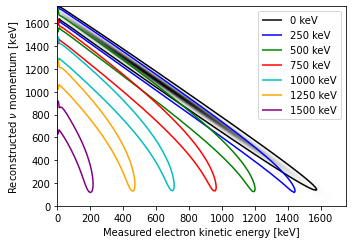

In [3]:
iso = 'p_32'

params = [50, 1e5]

save_dir = '/Users/dcmoore/grace/impulse/steriles/pdfs/'
of = open(save_dir + '%s_%.1f_%.1e_pdfs.pkl'%(iso,params[0],params[1]), 'rb')
pdfs = pickle.load(of)
of.close()


mass_list_str = pdfs.keys()
mass_list = []
for m in mass_list_str:
  cmass = float(m)
  if(cmass > 0):
    mass_list.append(cmass)

mass_list = sorted(mass_list)

ulim = np.ones_like(mass_list)*1e6

fig=plt.figure()

bkg_pdf = pdfs['0.0']
levs = [0.05,]

if( not iso in uu.beta_list):
  plt.semilogy(bkg_pdf[:,0], bkg_pdf[:,1], 'k')
else:
  x = bkg_pdf[:,:2]
  p = bkg_pdf[:,2:]
  print(np.shape(x), np.shape(p))
  p = p/np.max(p)
  #p[p==0] = np.nan
  p_orig = 1.0*p
  cs=plt.contour(x[:,0], x[:,1], p.T, levels=levs, colors='k')
  cs.collections[0].set_label("0 keV")
  plt.pcolormesh(x[:,0], x[:,1], p.T, cmap="Greys", rasterized=True, shading='gouraud')

  #plt.colorbar()
  #plt.title("$m_4 = 0$ keV")
  plt.xlabel("Measured electron kinetic energy [keV]")
  plt.ylabel(r"Reconstructed $\nu$ momentum [keV]")

ml = [250, 500, 750, 1000, 1250, 1500]
ml_idx = []
for mm in ml:
  ml_idx.append( mass_list[np.argmin(np.abs(np.array(mass_list)-mm))] )

print(ml_idx)

#plt.figure()

colors=['Greys', 'Blues', 'Greens', 'Reds', 'Oranges', 'Purples']
lcs = ['b', 'g', 'r', 'c', 'orange', 'purple']

cidx = 0
for i,m in enumerate(mass_list):

  if not m in ml_idx:
    continue

  print("working on mass: ", m)


  sig_pdf = pdfs['%.1f'%m]

  if( not iso in uu.beta_list):
    plt.semilogy(sig_pdf[:,0], sig_pdf[:,1])
  else:
    x = sig_pdf[:,:2]
    p = sig_pdf[:,2:]
    p = p/np.max(p)
    x = x[()] ## get the dict back from the 0d ndarray
    #plt.contour([x['bcx'], x['bcy']], p.T) #, levels=levs)
    #p[p<1e-4] = np.nan
    
    #plt.pcolormesh(x[:,0], x[:,1], p.T, cmap=colors[cidx])

    #plt.colorbar()
    cs=plt.contour(x[:,0], x[:,1], p.T, levels=levs, colors=lcs[cidx])
    cs.collections[0].set_label("%d keV"%(np.round(m/50)*50))
    cidx += 1
    #plt.title("$m_4 = %.1f$ keV"%m)
    plt.xlabel("Measured electron kinetic energy [keV]")
    plt.ylabel(r"Reconstructed $\nu$ momentum [keV]")

plt.xlim([0,1750])
plt.ylim([0,1750])
plt.legend()

fig.set_size_inches(5,3.5)
plt.tight_layout()
plt.savefig('p_32_2dplot.pdf')

plt.show()

In [36]:
def plot_limits(iso_list, isEC, fig, params_to_use, clist, fill=True, ls='-', doLegend=True):

    plt.figure(fig.number)
  
    for j,iso in enumerate(iso_list):

        flist = glob.glob("/Users/dcmoore/grace2/impulse/steriles/limits/%s*%.1e_%d_%.1f_%.1f_%.1e.npz"%(iso,*params_to_use))
        iso_dat = np.loadtxt("/Users/dcmoore/grace2/impulse/steriles/data_files/%s.txt"%iso, delimiter=',', skiprows=3)
        Q, t12, A, Z = iso_dat[0, :]

        for i,f in enumerate(flist):

            cdat = np.load(f)
            x = cdat['m']
            lim_vals = cdat['lim']
            
            good_vals = np.where(~(np.isnan(lim_vals)))[0] ## put to flat value at high mass (prior to phase space below)
            lim_vals[good_vals[-1]:] = lim_vals[good_vals[-1]]
            lim_vals[0] = np.nan
            
            if(iso == "be_7"):
                Q = 384.22 ## hard code the gamma that gets subtracted
                        ## should fix this for general case (maybe do this in the limit step or pdf?)
            xfine = np.linspace(x[0], Q, 10000)
            limfine = np.interp(xfine, x, lim_vals, left=np.nan, right=np.nan)

            if(isEC):
                massfac = np.sqrt(1 - xfine**2/Q**2)
            else:
                massfac = np.zeros_like(xfine)
                ee = np.linspace(0,Q,1000)
                massless_beta_norm = np.sum(uu.simple_beta(ee, Q, 0, A, Z))
                for mi, ms in enumerate(xfine):
                    massfac[mi] = np.sum(uu.simple_beta(ee, Q, ms, A, Z))/massless_beta_norm

            Q_idx = np.argmin(np.abs(xfine - Q))
            massfac[Q_idx] = 1e-10
            limfine /= massfac

            ## trim any nans and maker sure plot reaches top
            g = ~np.isnan(limfine)
            xfine, limfine = xfine[g], limfine[g]
            xfine = np.append(xfine, xfine[-1]+1e-15)
            limfine = np.append(limfine, 1)

            if(not i==0):
                p=plt.semilogy( xfine, limfine, ":", color=clist[i] )
                c=p[0].get_color()
                plt.fill_between(xfine, limfine, np.ones_like(limfine), edgecolor='none', facecolor=c, alpha=0.05)
            else:
                Z,A = iso.split('_')
                lab = "$^{%s}$%s"%( A, Z.capitalize() )
                if(fill or doLegend):
                    p=plt.semilogy( xfine, limfine, ls, label=lab, color=clist[j])
                else:
                    p=plt.semilogy( xfine, limfine, ls, color=clist[j])
                c=p[0].get_color()
                if(fill):
                    plt.fill_between(xfine, limfine, np.ones_like(limfine), edgecolor='none', facecolor=c, alpha=0.2)

    plt.ylim([1e-6,1])
    #plt.gca().set_xscale('log')
    if(isEC):
        plt.xlim([0,1100])
    else:
        plt.xlim([0,2500])
    plt.xlabel(r"Sterile $\nu$ mass, $m_4$ [keV]")
    plt.ylabel("$|U_{e4}|^2$")
    if(doLegend):
        plt.legend(loc='lower right')

In [44]:
def plot_prev_orig(main_dir = "/Users/dcmoore/grace2/impulse/steriles/"):
    prev_iso = ['be_7', 's_35', 're_187', 'ni_63', 'h_3', 'f_20', 'cu_64', 'ce_144', 'pienu']

    for piso in prev_iso:

        f = main_dir + "prev_lim/prev_lim_%s.txt"%piso
        curr_dat = np.loadtxt(f, delimiter=',', skiprows=1)

        p=plt.semilogy(curr_dat[:,0]*1e6, curr_dat[:,1], color='grey',lw=0.25)
        #c=p[0].get_color()
        plt.fill_between(curr_dat[:,0]*1e6, curr_dat[:,1], np.ones_like(curr_dat[:,1]), edgecolor='none', facecolor='grey', alpha=0.1)


In [38]:
def plot_prev(main_dir = "/Users/dcmoore/grace2/impulse/steriles/", max_val=2500):
    prev_iso = ['be_7', 's_35', 're_187', 'ni_63', 'h_3', 'f_20', 'cu_64', 'ce_144', 'pienu']
    lim_x = np.linspace(0,max_val,1000)
    lim_y = np.ones_like(lim_x)
    for piso in prev_iso:

        f = main_dir + "prev_lim/prev_lim_%s.txt"%piso
        curr_dat = np.loadtxt(f, delimiter=',', skiprows=1)

        new_lim = np.interp(lim_x,curr_dat[:,0]*1e6, curr_dat[:,1],left=np.nan, right=np.nan)
        gpts = ~np.isnan(new_lim)

        rpts = gpts & (new_lim < lim_y)
        lim_y[rpts] = new_lim[rpts]

    p=plt.semilogy(lim_x, lim_y, color='grey')
    c=p[0].get_color()
    plt.fill_between(curr_dat[:,0]*1e6, curr_dat[:,1], np.ones_like(curr_dat[:,1]), edgecolor='none', facecolor='grey', alpha=0.05)


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_32326/2007172076.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_32326/2007172076.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_32326/2007172076.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac


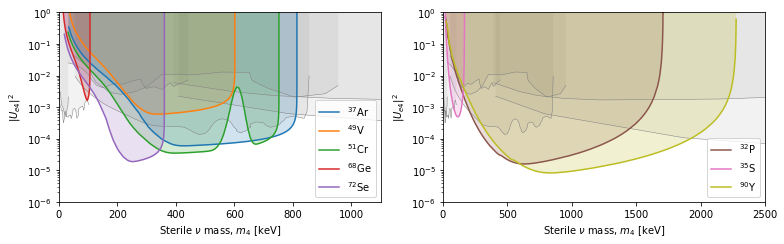

In [49]:
## plot for the paper (EC)


clist = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(clist)
params = [1e-2, 1, 30, 50, 1e5] ## 1% loading, 100 sphere days

iso_list = ["ar_37", "v_49", "cr_51", "ge_68", "se_72"]
isEC = True

fig=plt.figure()
plt.subplot(1,2,1)
plot_prev_orig()
plot_limits(iso_list, isEC, fig, params, clist)

## all done with 100 nm sphere except s_35 with 50 nm
nprev = len(iso_list)
iso_list = ["p_32","s_35","y_90"]
isEC = False

clist = clist[nprev:nprev+2] + clist[nprev+4:]
print(clist)
plt.subplot(1,2,2)

prev_iso = ['be_7', 's_35', 're_187', 'ni_63', 'h_3', 'f_20', 'cu_64', 'ce_144', 'pienu']
plot_prev_orig()
plot_limits(iso_list, isEC, fig, params, clist)
fig.set_size_inches(11,3.5)
plt.tight_layout()

plt.savefig("ue4_sensitivity.pdf")
plt.show()

curr dir:  /Volumes/GoogleDrive-108630187434314716047/My Drive/yale/uspheres/impulse/impulse/steriles


/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_32326/566390010.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_32326/566390010.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_32326/566390010.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_32326/566390010.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_32326/566390010.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_32326/566390010.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
/var/folders/sz/h29lm_2j53v8vmw0zm

KeyboardInterrupt: 

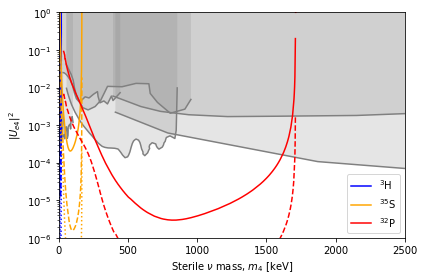

In [33]:
## plot the previous limits with the projections overlaid

prev_iso = ['be_7', 's_35', 're_187', 'ni_63', 'h_3', 'f_20', 'cu_64', 'ce_144', 'pienu']

fig=plt.figure()

print("curr dir: ", os.getcwd())

for piso in prev_iso:

    f = main_dir + "prev_lim/prev_lim_%s.txt"%piso
    curr_dat = np.loadtxt(f, delimiter=',', skiprows=1)

    p=plt.semilogy(curr_dat[:,0]*1e6, curr_dat[:,1], color='grey')
    c=p[0].get_color()
    plt.fill_between(curr_dat[:,0]*1e6, curr_dat[:,1], np.ones_like(curr_dat[:,1]), edgecolor='none', facecolor='grey', alpha=0.2)

nprev = len(iso_list)
iso_list = ["h_3","s_35","p_32",]
isEC = False

iso_dict = {"h_3": [[0.2, 1, 30, 25, 1e3],[0.2, 10, 365, 25, 1e3],[0.2, 1000, 365, 25, 1e3],],
            "s_35": [[1e-2, 1, 30, 50, 1e4],[1e-2, 10, 365, 50, 1e4],[1e-2, 1000, 365, 50, 1e4],],
            "p_32": [[1e-2, 1, 30, 100, 1e5],[1e-2, 10, 365, 100, 1e5],[1e-2, 1000, 365, 100, 1e5],]
        }

clist = ['b','orange', 'r']
lslist = ['-', '--', ':']
for col,iso in zip(clist,iso_dict.keys()):
    
    iso_list = [iso,]
    params_list = iso_dict[iso]
    
    for ls,params in zip(lslist,params_list):
        if(ls == "-"): 
            dl = True
        else:
            dl = False
        plot_limits(iso_list, isEC, fig, params, [col,], fill=False, ls=ls, doLegend=dl)
    plt.tight_layout()

plt.xlim([1,2500])
plt.ylim([1e-10, 0.1])
plt.gca().set_xscale('log')
plt.legend(loc='lower left')
fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig("ue4_sens_vs_livetime.pdf")
plt.show()
    

/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_2763/4008851229.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
No handles with labels found to put in legend.
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_2763/4008851229.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
No handles with labels found to put in legend.


(1e-09, 0.1)

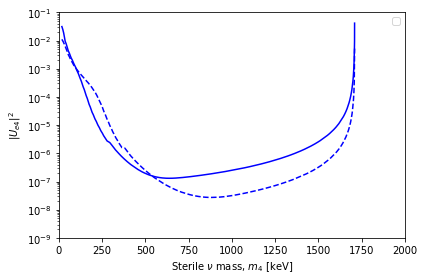

In [7]:
##plot vs sphere size

iso_list = ["p_32",]
isEC = False

params_list = [[1e-2, 10, 365, 50, 1e5],
               [1e-2, 10, 365, 100, 1e5],] 

clist = ['b',]
lslist = ['-', '--']
for ls,params in zip(lslist,params_list):
    plot_limits(iso_list, isEC, fig, params, clist, fill=False, ls=ls)
plt.tight_layout()

plt.xlim([0,2000])
plt.ylim([1e-9, 0.1])

curr dir:  /Volumes/GoogleDrive-108630187434314716047/My Drive/yale/uspheres/impulse/impulse/steriles


/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_42227/215649045.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_42227/215649045.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac
/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_42227/215649045.py:38: RuntimeWarning: divide by zero encountered in true_divide
  limfine /= massfac


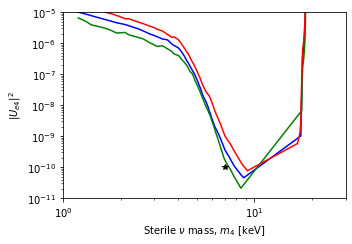

In [8]:
## plot vs sphere and isotope

prev_iso = ['be_7', 's_35', 're_187', 'ni_63', 'h_3', 'f_20', 'cu_64', 'ce_144', 'pienu']

fig=plt.figure()

print("curr dir: ", os.getcwd())

for piso in prev_iso:

    f = "/Users/dcmoore/grace2/impulse/steriles/prev_lim/prev_lim_%s.txt"%piso
    curr_dat = np.loadtxt(f, delimiter=',', skiprows=1)

    p=plt.semilogy(curr_dat[:,0]*1e6, curr_dat[:,1], color='grey')
    c=p[0].get_color()
    plt.fill_between(curr_dat[:,0]*1e6, curr_dat[:,1], np.ones_like(curr_dat[:,1]), edgecolor='none', facecolor='grey', alpha=0.2)

iso_list = ["p_32",]
isEC = False

#iso_dict = { "h_3": [[35, 1e3],[50, 1e3],[35, 5e2],[50, 5e2],[100, 1e2],],}

iso_dict = {"h_3_1": [[50, 1e1],],
            "h_3_2": [[75, 1e1],],
            "h_3_3": [[35, 1e1],],
            #"s_35": [[50, 1e4],],
            #"p_32": [[100, 1e5],],
        }

params_list = [#[1e-2, 10, 365],
               [0.2, 1000000, 5*365],] 

clist = ['b','g','r','c','m','k','orange','purple']
lslist = ['-', ':']
for j,iso in enumerate(iso_dict.keys()):
    for ls,params in zip(lslist,params_list):
        cparams = [*params, *iso_dict[iso][0]]
        plot_limits([iso[:-2],], isEC, fig, cparams, clist[j], fill=False, ls=ls)
plt.tight_layout()

plt.xlim([1,30])
plt.ylim([1e-11, 1e-5])
plt.gca().set_xscale('log')

plt.plot(7,1e-10, 'k*')

fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig("ue4_sens_vs_livetime.pdf")
plt.show()
    

(249, 2) (249, 249)
[5e-05]
[5e-05, 0.0001]
[5e-05, 0.0001, 0.0002]
[5e-05, 0.0001, 0.0002, 0.0008]
working on mass:  5e-05
working on mass:  0.0001
working on mass:  0.0002
working on mass:  0.0008
(249, 2) (249, 249)
[5e-05]
[5e-05, 0.0001]
[5e-05, 0.0001, 0.0002]
[5e-05, 0.0001, 0.0002, 0.0008]
working on mass:  5e-05
working on mass:  0.0001
working on mass:  0.0002
working on mass:  0.0008


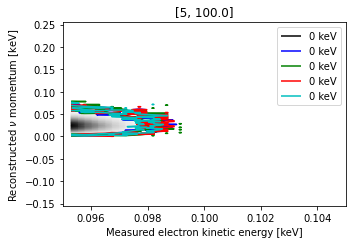

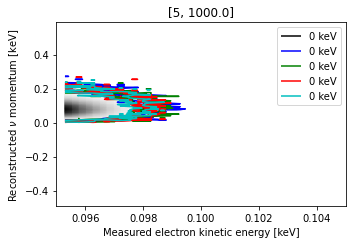

In [19]:
iso = 'x_100'

min_x = 0.095

params_list = [[5, 1e2],[5, 1e3],]

for params in params_list:


    save_dir = '/Users/dcmoore/grace/impulse/steriles/pdfs/'
    of = open(save_dir + '%s_%.1f_%.1e_pdfs.pkl'%(iso,params[0],params[1]), 'rb')
    pdfs = pickle.load(of)
    of.close()


    mass_list_str = pdfs.keys()
    mass_list = []
    for m in mass_list_str:
        cmass = float(m)
        if(cmass > 0):
            mass_list.append(cmass)

    mass_list = sorted(mass_list)

    ulim = np.ones_like(mass_list)*1e6

    fig=plt.figure()

    if '0.0' in pdfs.keys():
        bkg_pdf = pdfs['0.0']
    else:
        bkg_pdf = pdfs['0.000000']
    levs = [0.01,0.05]

    if( not iso in uu.beta_list):
        plt.semilogy(bkg_pdf[:,0], bkg_pdf[:,1], 'k')
    else:
        x = bkg_pdf[:,:2]
        p = bkg_pdf[:,2:]

        gpts = x[:,0] > min_x

        print(np.shape(x), np.shape(p))
        p = p/np.max(p[gpts,:])
        #p[p==0] = np.nan
        p_orig = 1.0*p
        cs=plt.contour(x[gpts,0], x[:,1], p[gpts,:].T, levels=levs, colors='k')
        cs.collections[0].set_label("0 keV")
        plt.pcolormesh(x[gpts,0], x[:,1], p[gpts,:].T, cmap="Greys", rasterized=True, shading='gouraud')

        #plt.colorbar()
        #plt.title("$m_4 = 0$ keV")
        plt.xlabel("Measured electron kinetic energy [keV]")
        plt.ylabel(r"Reconstructed $\nu$ momentum [keV]")

        ml = [50e-6, 100e-6, 200e-6, 800e-6]
        ml_idx = []
        
        for mm in ml:
            ml_idx.append( mass_list[np.argmin(np.abs(np.array(mass_list)-mm))] )

            print(ml_idx)

        #plt.figure()

        colors=['Greys', 'Blues', 'Greens', 'Reds', 'Oranges', 'Purples']
        lcs = ['b', 'g', 'r', 'c', 'orange', 'purple']

        cidx = 0
        for i,m in enumerate(mass_list):

            if not m in ml_idx:
                continue

            print("working on mass: ", m)


            sig_pdf = pdfs['%.6f'%m]

            if( not iso in uu.beta_list):
                plt.semilogy(sig_pdf[:,0], sig_pdf[:,1])
            else:
                x = sig_pdf[:,:2]
                p = sig_pdf[:,2:]

                gpts = x[:,0] > min_x

                p = p/np.max(p[gpts,:])
                x = x[()] ## get the dict back from the 0d ndarray
                #plt.contour([x['bcx'], x['bcy']], p.T) #, levels=levs)
                #p[p<1e-4] = np.nan
                
                #plt.pcolormesh(x[:,0], x[:,1], p.T, cmap=colors[cidx])

                #plt.colorbar()
                cs=plt.contour(x[gpts,0], x[:,1], p[gpts,:].T, levels=levs, colors=lcs[cidx])
                cs.collections[0].set_label("%d keV"%(np.round(m/50)*50))
                cidx += 1
                #plt.title("$m_4 = %.1f$ keV"%m)
                plt.xlabel("Measured electron kinetic energy [keV]")
                plt.ylabel(r"Reconstructed $\nu$ momentum [keV]")

            #plt.xlim([0,20])
            #plt.ylim([0,20])
            plt.legend()

            fig.set_size_inches(5,3.5)
            plt.tight_layout()
            #plt.savefig('p_32_2dplot.pdf')
            plt.xlim(min_x, 0.1 + (0.1-min_x))
            plt.title(params)

plt.show()

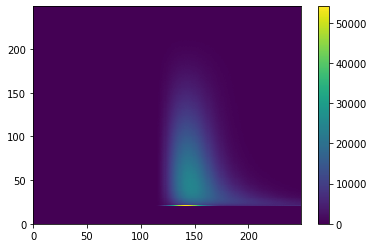

In [6]:
f = np.load('/Users/dcmoore/grace2/impulse/steriles/data_files/x_100_mnu_0.000000_rad_5.0_f0_1.0e+03_pdf_0.npz')
plt.pcolormesh(f['pdf'])
plt.colorbar()

/Volumes/GoogleDrive-108630187434314716047/My Drive/yale/uspheres/impulse/impulse/steriles/usphere_utils.py:79: RuntimeWarning: overflow encountered in exp
  f[gpts] = 2*(1 + np.sqrt(1-alpha**2 * Z**2) ) * (2*p*R)**eval * np.exp(np.pi*alpha*Z*Et/p) * gam
/Volumes/GoogleDrive-108630187434314716047/My Drive/yale/uspheres/impulse/impulse/steriles/usphere_utils.py:79: RuntimeWarning: invalid value encountered in multiply
  f[gpts] = 2*(1 + np.sqrt(1-alpha**2 * Z**2) ) * (2*p*R)**eval * np.exp(np.pi*alpha*Z*Et/p) * gam


0
num nan 0
[0.0058901  0.02541123 0.01395079 0.04226376 0.00591852 0.04905418
 0.02488214 0.01825141 0.0060492  0.01694181]
1838757.3219300702
[0.02065539 0.05295274 0.00435771 0.01335888 0.08251159 0.00530054
 0.02333422 0.01134725 0.01600226 0.0094625 ]


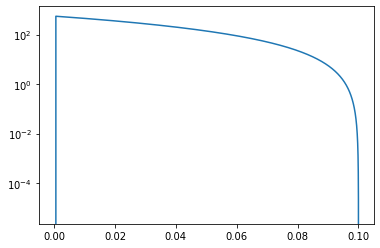

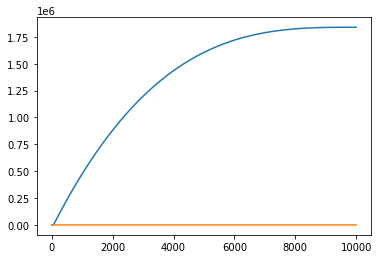

In [2]:
elec_e_vals = np.linspace(0, 0.1, int(1e4))
sb=uu.simple_beta(elec_e_vals,0.1, 0, 100, 45)
print(np.sum(np.isnan(sb)))
plt.semilogy(elec_e_vals, sb)

print("num nan", np.sum(np.isnan(sb)))

print(uu.draw_from_pdf(10, elec_e_vals, sb))

cdf = np.cumsum(sb)
plt.figure()
plt.plot(cdf)
print(np.max(cdf))
cdf /= np.max(cdf)
plt.plot(cdf)
rv = np.random.rand(10)
print(np.interp(rv, cdf, elec_e_vals))

In [93]:
## calculate livetime to get n decays

def n_decay_per_lt(livetime, iso, loading_frac, t12, A, tot_prob, sphere_rad = 50e-9):

    if(livetime < 0):
        livetime = 0

    trig_prob = 0.4


    m_sph = 4/3 * np.pi * sphere_rad**3 * uu.rho
    n_nuclei = m_sph * uu.N_A/A * loading_frac 

    if(livetime < t12):
        n_decays = int(trig_prob * n_nuclei * (1 - 0.5**(livetime/t12) ))
    else:
        ## assume the sphere is reloaded once per half-life
        niters = np.floor(livetime/t12)
        livetime_remain = livetime % t12
        #print("Working on %d halflives and %f days remaining"%(niters, livetime_remain))
        n_decays = trig_prob * niters * 0.5*n_nuclei + int(trig_prob * n_nuclei * (1 - 0.5**(livetime_remain/t12) ))
    return (n_decays*tot_prob)

In [99]:

#iso = ['be_7', 'ar_37', 'v_49', 'cr_51', 'ge_68', 'se_72']
iso = ['p_32']
loading_frac = 0.01

ndays = np.linspace(1,2000,2000)

for i in iso:

    iso_dat = np.loadtxt("/Users/dcmoore/grace/impulse/steriles/data_files/%s.txt"%i, delimiter=',', skiprows=3)
    Q, t12, A, Z = iso_dat[0, :]

    seconds = iso_dat[1:,:]
    tot_prob = np.sum(seconds[:,0])

    ndecays = np.zeros_like(ndays)
    for j,n in enumerate(ndays):
        ndecays[j] = n_decay_per_lt(n, i, loading_frac, t12, A, tot_prob, sphere_rad=50e-9)

    print(i, np.interp(1e4, ndecays, ndays))

p_32 2.7976401179941
